### DATA620 - Final Project Proposal
#### Michael Ippolito
7/7/2022

### Project Overview

It is common knowledge that many world languages are related to each other, with some borrowing words from others. For this project, I propose to investigate similar words across various world languages, with the end goal of quantifying which languages are most similar to each other. This may also show relationships in the form of "family trees," with languages that have higher centrality metrics being more likely to have been predecessors of its neighbors. Specifically, I'll focus on evaluating which languages are most similar to English. This isn't intended to be a comprehensive etymological study, but instead an application of both NLP and network graphs to perform a specific, limited analysis.

Since the corpus of world languages is vast, I propose to limit the texts I'll evaluate to a small subset of languages. Further, I propose limiting the text from each language to a specific set of documents translated across all languages I'll evaluate in the project, namely the Universal Declaration of Human Rights (https://www.un.org/en/about-us/universal-declaration-of-human-rights). The UDHR comes packaged into the NLTK and is translated into 335 languages with various encodings. For the purposes of this project, I'll limit the number of languages; in my exploratory investigation, I chose nineteen languages spoken in Europe and which can be expressed using the latin-1 character set. Based on my exploratory data analysis, limiting the scope in this way yielded approximately 11,000 unique words, many of which are shared among multiple languages.

I expect to have to perform a bipartite projection, since my dataset will consist of words linked to languages. I further anticipate that a number of centrality measure will be helpful, e.g. degree, betweenness, closeness, eigenvector.

Preliminary EDA follows, which I performed to evaluate the feasibility of the project.


In [21]:
# Load libraries
import matplotlib.pyplot as plt
import csv
import os
import numpy as np
from scipy import stats
import pandas as pd
from collections import Counter
import plotly.express as px
import plotly.io as pio
import nltk
import math
import collections
import time
import re
from nltk.corpus import udhr
import networkx as nx
import networkx.algorithms.bipartite as bipartite

# Set module options
pio.renderers.default = 'jupyterlab'       # Set ploty renderer so graphs show up in HTML output
pd.set_option('display.width', 160)        # Set pandas display options
pd.set_option('display.max_colwidth', 80)  # Set max width of each column


#### Word normalization

First, I'll devise a word normalization strategy. This will be necessary to try correlating between words which are essentially the same across multiple languages, but whose spelling is slightly different. For example, the following words should be treated as equivalent:

| Language | Word |
| -------- | ---- |
| English | operation |
| Spanish | operación |
| French | opération |
| Portuguese | operação |
| Latin | operatio |

Note the accent over the "o" in Spanish, over the "e" in French, and over the "a" in Portuguese. Likewise, the "ção" in the Portuguese word can be converted to "tion." These should all be normalized to the stem "operat." For the purposes of EDA in this proposal, I'll only convert to lowercase and will save the rest for the full project.


In [22]:
# Preliminary function to normalize word; I expect to add more to this later, e.g. lemmatizing and replacing extended characters with English equivalents
def normalizeWord(word):
    r = word.lower()
    return r


#### Loading and tokenizing the data

Here I define which languages I'll be evaluating, although I may try to expand this to other regions of the word using other character sets. But for now, I'll limit the scope to nineteen languages commonly spoken throughout Europe. After that, I'll load the UDHR from the files provided by the NLTK and run them through the normalizing function.


In [27]:
# From C:\Users\micha\AppData\Roaming\nltk_data\corpora\udhr
# Choose nineteen languages spoken in Europe, whose written alphabet can be expressed using the latin-1 character set
languages = [
    'Danish_Dansk',
    'Dutch_Nederlands',
    'Catalan_Catala',
    'English',
    'Estonian_Eesti',
    'Finnish_Suomi',
    'French_Francais',
    'German_Deutsch',
    'Hungarian_Magyar',
    'IrishGaelic_Gaeilge',
    'Italian_Italiano',
    'Latin_Latina',
    'Latvian',
    'Luxembourgish_Letzebuergeusch',
    'Norwegian_Norsk-Bokmal',
    'Portuguese_Portugues',
    'Rhaeto-Romance_Rumantsch',
    'Spanish_Espanol',
    'Swedish_Svenska'
]

# Iterate through the languages, reading each one from the NLTK's UDHR dataset
w = {}
for lang in languages:
    w[lang] = set([])
    # Read words from each file
    for word in udhr.words(lang + '-Latin1'):
        # Only choose alphabetic words, including extended characters from the latin-1 character set
        if re.match(r'^[A-Za-z\u00C0-\u00D6\u00D8-\u00f6\u00f8-\u00ff]+$', word):
            # Add the word to the set
            w[lang].add(normalizeWord(word))


#### Build network graph

Continuing EDA, the network graph is built. Each node is either a language or a word. A language connects to a word (and vice versa) in an undirected fashion. For EDA, I didn't place any weights on the edges, but I expect that I'll want to weight them based on frequency of occurence.


In [28]:
# Create new blank networkx graph
g = nx.Graph()

# Iterate through each language
for lang in w.keys():
    g.add_node(lang, bipartite=0)    # add the language as a top node
    ct = 0    # counter of words in this language
    ctoverlap = 0    # counter of words so far that overlap across languages
    for word in w[lang]:
        ct += 1
        overlap = len([n[0] for n in g.nodes(data=True) if n[0] == word and n[1]['bipartite'] == 1])    # only count it if the word overlaps, not the language name
        ctoverlap += overlap
        if overlap == 0:
            g.add_node(word, bipartite=1)    # add the word as a bottom node
        g.add_edge(lang, word)               # connect the language to the word as an edge
    print(lang + ': ' + str(ct) + ' words, overlap=' + str(ctoverlap))


Danish_Dansk: 537 words, overlap=0
Dutch_Nederlands: 472 words, overlap=14
Catalan_Catala: 512 words, overlap=7
English: 484 words, overlap=38
Estonian_Eesti: 638 words, overlap=4
Finnish_Suomi: 662 words, overlap=9
French_Francais: 523 words, overlap=85
German_Deutsch: 535 words, overlap=41
Hungarian_Magyar: 609 words, overlap=8
IrishGaelic_Gaeilge: 573 words, overlap=20
Italian_Italiano: 533 words, overlap=39
Latin_Latina: 703 words, overlap=35
Latvian: 646 words, overlap=10
Luxembourgish_Letzebuergeusch: 549 words, overlap=78
Norwegian_Norsk-Bokmal: 542 words, overlap=219
Portuguese_Portugues: 542 words, overlap=106
Rhaeto-Romance_Rumantsch: 545 words, overlap=112
Spanish_Espanol: 494 words, overlap=176
Swedish_Svenska: 553 words, overlap=100


#### Word overlap

Doing some preliminary EDA, investigate which words overlap across multiple languages.


Main dataframe containing languages and words:


,lang,word
0,Danish_Dansk,andre
1,Danish_Dansk,valgte
2,Danish_Dansk,områder
3,Danish_Dansk,familie
4,Danish_Dansk,national
...,...,...
10647,Swedish_Svenska,lands
10648,Swedish_Svenska,grym
10649,Swedish_Svenska,nationer
10650,Swedish_Svenska,handling



Overlapping words:


,lang,words,overlap
0,Danish_Dansk,537,243
0,Dutch_Nederlands,472,51
0,Catalan_Catala,512,148
0,English,484,99
0,Estonian_Eesti,638,21
0,Finnish_Suomi,662,12
0,French_Francais,523,114
0,German_Deutsch,535,68
0,Hungarian_Magyar,609,12
0,IrishGaelic_Gaeilge,573,26



Overlapping words in English:


,word,lang
4,national,Danish_Dansk
3308,national,French_Francais
3312,distinction,French_Francais
9073,member,Rhaeto-Romance_Rumantsch
562,in,Dutch_Nederlands
...,...,...
9558,secret,Rhaeto-Romance_Rumantsch
3806,oppression,French_Francais
3818,part,French_Francais
9590,part,Rhaeto-Romance_Rumantsch


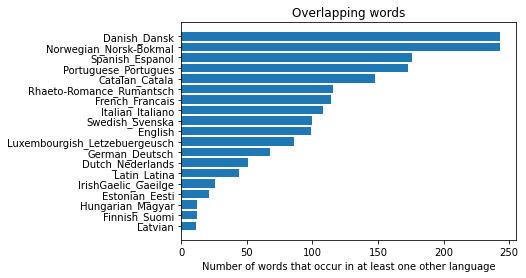

In [32]:
# Create dict to store languages and words, which we'll convert to a dataframe
newdict = {'lang': [], 'word': []}

# Iterate through the languages in the tokenized word dict
for lang in w.keys():
    # Iterate through each word in this language
    for word in w[lang]:
        newdict['lang'].append(lang)    # append the language to the dict of lists
        newdict['word'].append(word)    # append the word to the dict of lists

# Convert the dict to a dataframe
df1 = pd.DataFrame.from_dict(newdict)
print('Main dataframe containing languages and words:')
display(df1)
print()

# Create a dataframe to show which words overlap other languages
dfoverlap = pd.DataFrame(columns=['lang', 'words', 'overlap'])

# Create a dataframe to specifically look at English words that overlap other languages
dfEngOverlap = pd.DataFrame(columns=['word', 'lang'])

# Iterate through the languages in the tokenized word dict
for lang in w.keys():
    dflang = df1[df1['lang'] == lang]           # the series of words in this specific language
    dfotherlangs = df1[df1['lang'] != lang]     # the series of words for every language *except* for this specific language
    overlapTotal = 0 
    # Iterate through each word in this language
    for word in dflang['word']:
        # Generate a series listing all other languages that contain this word
        dfotherlangWords = dfotherlangs[dfotherlangs['word'] == word]
        overlapct = int(dfotherlangWords.shape[0] > 0)    # increment counter if there are more than zero languages that overlap this word
        overlapTotal += overlapct                # overall total of overlapping words
        # Add the entry to the English dataframe
        if lang == 'English':
            dfEngOverlap = pd.concat([dfEngOverlap, pd.DataFrame.from_dict({'word': [word] * dfotherlangWords.shape[0],'lang': dfotherlangWords['lang']})])
    # Add the entry to the overall overlap dataframe
    dfoverlap = pd.concat([dfoverlap, pd.DataFrame.from_dict({'lang': [lang], 'words': [dflang['word'].shape[0]], 'overlap': [overlapTotal]})])

# Display the dataframes
print('Overlapping words:')
display(dfoverlap)
print()
print('Overlapping words in English:')
display(dfEngOverlap)
print()

# Overlapping words bar chart
dfoverlap.sort_values(['overlap'], inplace=True)
plt.barh(y=dfoverlap['lang'], width=dfoverlap['overlap'])
plt.title('Overlapping words')
plt.xlabel('Number of words that occur in at least one other language')
plt.show()


#### Preliminary projection

For EDA, do a preliminary projection of languages onto the main graph. This will help in assessing how many (if any) languages are related to English.


In [30]:
# Assign top and bottom nodes (languages and words, respectively)
langs = [n[0] for n in g.nodes(data=True) if n[1]['bipartite'] == 0]
words = [n[0] for n in g.nodes(data=True) if n[1]['bipartite'] == 1]

# Project languages onto graph
gp = bipartite.weighted_projected_graph(g, langs)


#### Bipartite projection graph

Draw a bipartite projection graph illustrating how languages relate to each other. As shown, each language is related to every single other language through at least one word. For the real project, I expect to add weights to those relationships based on the number of words in common. From there, I'll trim the ones with the smallest weights, leaving those that have the most words in common.


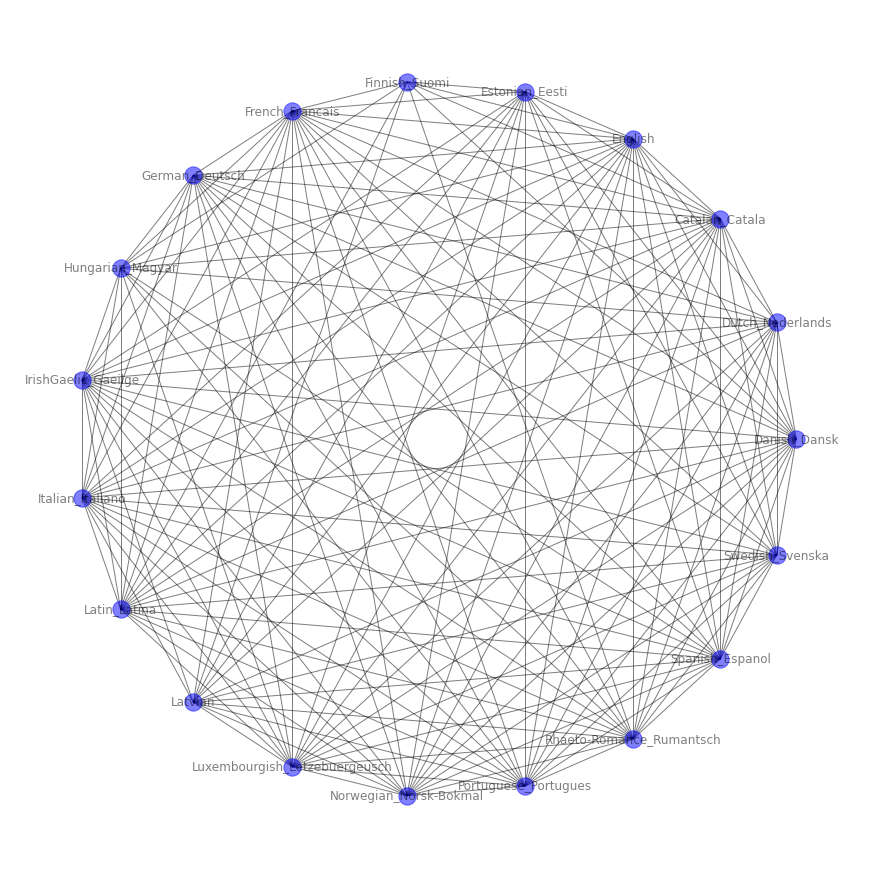

In [31]:
# Plot bipartite projection graph
plt.figure(1, figsize=(12,12)) 
options = {
    'node_color': 'blue',
    'node_size': 300,
    'width': 1,
    'alpha': 0.5
}
nx.draw_circular(gp, **options, with_labels=True)
plt.show()


#### Limitations and concerns

One severe limitation will be that, without a full understanding of each language, some words may be marked as equivalent, when they actually have vastly different meanings. For example, the word "be" in Romansch doesn't mean the same thing as the English word "be"; it actually means "just," "only," or "exclusively." But for the purposes of this project, I won't have a comprehensive way to make that distinction.

Another limitation I've found is that even moderately sized NetworkX graphs take a long time to display and process. A network with 11,000 nodes is relatively small, and yet it took several minutes to diagram.

One additional concern, as shown in the bipartite projection graph, is that each language appears to be related to every single other language. This indicates I'll need to add weights (e.g. number of words in common) to further evaluate how each language relates to the others.

And finally, it is well known that some languages are naturally more closely related to each other, e.g. Norwegian and Danish. As shown in the bar chart above, these top the list, but it isn't immediately apparent whether they are only closely related to each other or whether they share many common words across all languages. I expect adding weights to the edges will suss out those differences.
